### Load Packages

In [1]:
# primary EDA code
import pandas as pd
import numpy as np
import os

# packages for plots
import matplotlib.pyplot as plt

# warning ignore
import warnings
warnings.filterwarnings("ignore")

# packages for ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# packages for cross-validation
from sklearn.model_selection import KFold

### Load BUY Data & Split into parts

In [2]:
df_gp = pd.DataFrame()

print("Loading (BUY) stock data:")
for filename in os.listdir('data/buy/'):
    if filename.endswith(".txt"): 
        stock = filename[0:4]
        print(stock, " ", end = '')
        temp_df = pd.read_csv(os.path.join('data/buy/', filename), delimiter= '\s+', header = None)
        temp_df.rename(columns={123:'rtn'}, inplace=True)
        temp_df = pd.concat([pd.Series([stock] * temp_df.shape[0], name = 'stock'), temp_df], axis=1)
        temp_df = temp_df.iloc[21:,:]
        df_gp = pd.concat([df_gp, temp_df])
        continue
    else:
        continue
        
df_gp = df_gp.reset_index(drop=True)

Loading (BUY) stock data:
adbe  ions  ssys  ati1  itub  alny  pxd1  ufs1  bac1  uri1  clf1  gs1B  jnpr  crm1  mas1  crus  pru1  bidu  fslr  csiq  jec1  db1B  acad  amd1  cenx  teck  meli  

In [3]:
name_gp = df_gp.iloc[:, 0]
osc_gp = df_gp.iloc[:, 1:42]
stk_gp = df_gp.iloc[:, 42:83]
macd_gp = df_gp.iloc[:, 83:124]
rtn_gp = df_gp.iloc[:, 124]
label_gp = np.sign(rtn_gp).map({1: 1, -1: 0, 0:0})

### Feature Engineering - add Smoothiness & Derivatives

In [4]:
# define function to calculate smoothness
def smooth_generator(data):
    smooth_list = []
    for i in range(data.shape[0]):
        smooth_list.append(np.var(abs(np.diff(data.iloc[i,:]))))
    smooth = pd.DataFrame(smooth_list, columns=["smooth"]) 

    return smooth

In [5]:
# define function for numerical differentiation
def derivative(data, space = 1, name = "macd"):
    dy = []
    for i in range(data.shape[0]):
        y = pd.Series(data.iloc[i,:])
        temp_dy = list(np.gradient(y, space))
        dy.append(temp_dy)
    
    col_name = []
    for i in range(data.shape[1]):
        col_name.append(name + "deriv"+ str(i))
        
    deriv_df = pd.DataFrame(dy, columns=col_name) 
    
    return deriv_df

In [6]:
# Factor for smoothness
smooth_osc = smooth_generator(osc_gp)
# calculate the dy for macd
first_deriv_macd = derivative(macd_gp)    
# calculate the ddy for macd
second_deriv_macd = derivative(first_deriv_macd) 

### Combine Selected Features

In [7]:
Feature_matrix_w_rtn = pd.concat([rtn_gp, osc_gp, stk_gp, macd_gp, smooth_osc, first_deriv_macd, second_deriv_macd], axis=1)

In [8]:
# Split test set
X_w_rtn, X_test_w_rtn, y, y_test = train_test_split(Feature_matrix_w_rtn, label_gp, test_size=0.2)

# Separate returns from Feature matrix
X_test = X_test_w_rtn.iloc[:, 1:]
rtn_test = X_test_w_rtn.iloc[:, 0]

# Reset Indices on All
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
rtn_test = rtn_test.reset_index(drop=True)

### Random Forest Classifier for BUY - (Raw) Log Proba Output

In [9]:
# Split test set
X_train_w_rtn, X_valid_w_rtn, y_train, y_valid = train_test_split(X_w_rtn, y, test_size=0.2)

# Separate returns from Feature matrix
X_train = X_train_w_rtn.iloc[:, 1:]
X_valid = X_valid_w_rtn.iloc[:, 1:]

rtn_train = X_train_w_rtn.iloc[:, 0]
rtn_valid = X_valid_w_rtn.iloc[:, 0]

# Reset indices on all
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
rtn_train = rtn_train.reset_index(drop=True)
    
X_valid = X_valid.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
rtn_valid = rtn_valid.reset_index(drop=True)
    
# Fit Random Forest
rf = RandomForestClassifier(n_estimators = 10)
rf.fit(X_train, y_train)
    
# Extracts the probabilities of being a good trade
log_proba_set_valid = rf.predict_log_proba(X_valid)
log_proba_valid = []
for prob in range(len(log_proba_set_valid)):
    log_proba_valid.append(log_proba_set_valid[prob][1])
    
# Classify the Classes of the Trades based on Log Proba of signal being a 1:
# Log Proba 0 - Excellent
# Log Proba -0.1 or above - Great
# Log Proba -0.11 - -0.22 - Good
# Log Proba < -0.23 - Average
trade_classes = ['Average'] * len(log_proba_valid)
for i in range(len(log_proba_valid)):
    if log_proba_valid[i] == 0:
        trade_classes[i] = 'Excellent'
    elif log_proba_valid[i] > -0.11:
        trade_classes[i] = 'Great'
    elif log_proba_valid[i] > -0.23:
        trade_classes[i] = 'Good'
    
# Put Results Together
results = pd.concat([pd.DataFrame(log_proba_valid), pd.DataFrame(trade_classes), y_valid, rtn_valid], axis =1)
results.columns = ['prob', 'trade_class', 'label', 'return']
results['prob'] = np.round(np.exp(results['prob']),1)
    
# Make Results Summary
results_summary = pd.concat([results.groupby(['prob']).mean()['label'], results.groupby(['prob']).count()['label'], results.groupby(['prob']).mean()['return']],axis=1)
results_summary.columns = ['WinRate', 'Count', 'Avg. Return']
results_summary['% of All Trades'] = np.round(results_summary['Count']/np.sum(results_summary['Count']),4)*100
results_summary = results_summary[results_summary.Count > 5]

results_summary
    

,WinRate,Count,Avg. Return,% of All Trades
prob,,,,
0.0,0.202765,217,-0.604332,1.29
0.1,0.319661,707,-0.137680,4.20
0.2,0.366890,1788,-0.041572,10.62
0.3,0.400631,3170,0.077028,18.84
0.4,0.405305,3770,0.046430,22.40
0.5,0.411025,3501,0.025496,20.80
0.6,0.429076,2263,0.119554,13.45
0.7,0.414607,890,-0.003629,5.29
0.8,0.544444,360,0.315306,2.14


### Random Forest Classifier for BUY - Trades Classes Outputs

In [10]:
# Make Results Summary
results_summary = pd.concat([results.groupby(['trade_class']).mean()['label'], results.groupby(['trade_class']).count()['label'], results.groupby(['trade_class']).mean()['return']],axis=1)
results_summary.columns = ['WinRate', 'Count', 'Avg. Return']
results_summary['% of All Trades'] = np.round(results_summary['Count']/np.sum(results_summary['Count']),4)*100
results_summary = results_summary[results_summary.Count > 5]

results_summary.reindex(['Excellent', 'Great', 'Good', 'Average'])
    

,WinRate,Count,Avg. Return,% of All Trades
trade_class,,,,
Excellent,0.891304,46,1.001739,0.27
Great,0.737288,118,1.081017,0.70
Good,0.544444,360,0.315306,2.14
Average,0.398810,16306,0.029007,96.89


### Random Forest Classifier for BUY - Trade Classes Output + 5-fold Cross-Validation

In [11]:
results_summaries_collection = pd.DataFrame()

# n-fold Cross Validation
kf = KFold(n_splits=5)
kf.get_n_splits(X_w_rtn)

# Within each fold
for train_index, test_index in kf.split(X_w_rtn):

    # Define train/ validation set (convert X_w_rtn and y to np.array for indexing on the next line)
    X_train_w_rtn, X_valid_w_rtn = X_w_rtn.values[train_index], X_w_rtn.values[test_index]
    y_train, y_valid = y.values[train_index], y.values[test_index]
    
    # Separate returns from Feature matrix (convert X_w_rtn and y back to pandas)
    X_train = pd.DataFrame(X_train_w_rtn).iloc[:, 1:]
    X_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 1:]

    rtn_train = pd.DataFrame(X_train_w_rtn).iloc[:, 0]
    rtn_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 0]
    
    y_train = pd.Series(y_train)
    y_valid = pd.Series(y_valid)
    
    # Reset indices on all
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    rtn_train = rtn_train.reset_index(drop=True)
    
    X_valid = X_valid.reset_index(drop=True)
    y_valid = y_valid.reset_index(drop=True)
    rtn_valid = rtn_valid.reset_index(drop=True)
    
    # Fit Random Forest
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    
    # Extracts the probabilities of being a good trade
    log_proba_set_valid = rf.predict_log_proba(X_valid)
    log_proba_valid = []
    for prob in range(len(log_proba_set_valid)):
        log_proba_valid.append(log_proba_set_valid[prob][1])
    
    # Classify the Classes of the Trades based on Log Proba of signal being a 1:
    # Log Proba 0 - Excellent
    # Log Proba -0.1 or above - Great
    # Log Proba -0.11 - -0.22 - Good
    # Log Proba < -0.23 - Average
    trade_classes = ['Average'] * len(log_proba_valid)
    for i in range(len(log_proba_valid)):
        if log_proba_valid[i] == 0:
            trade_classes[i] = 'Excellent'
        elif log_proba_valid[i] > -0.11:
            trade_classes[i] = 'Great'
        elif log_proba_valid[i] > -0.23:
            trade_classes[i] = 'Good'
    
    # Put Results Together
    results = pd.concat([pd.DataFrame(log_proba_valid), pd.DataFrame(trade_classes), y_valid, rtn_valid], axis =1)
    results.columns = ['prob', 'trade_class', 'label', 'return']
    results['prob'] = np.round(np.exp(results['prob']),1)
    
    # Make Results Summary
    results_summary = pd.concat([results.groupby(['trade_class']).mean()['label'], results.groupby(['trade_class']).count()['label'], results.groupby(['trade_class']).mean()['return']],axis=1)
    results_summary.columns = ['WinRate', 'Count', 'Avg. Return']
    results_summary['% of All Trades'] = np.round(results_summary['Count']/np.sum(results_summary['Count']),4)*100
    
    # Store it in the Results Collection
    results_summaries_collection = pd.concat([results_summaries_collection, results_summary])

In [12]:
results_summaries_collection.groupby(['trade_class']).mean().reindex(['Excellent', 'Great', 'Good', 'Average'])

,WinRate,Count,Avg. Return,% of All Trades
trade_class,,,,
Excellent,0.953569,45.0,1.599866,0.268
Great,0.715282,114.2,0.915783,0.678
Good,0.544381,353.6,0.377594,2.102
Average,0.402608,16317.2,0.033109,96.954


In [13]:
# Test Set
# Extracts the probabilities of being a good trade
log_proba_set_test = rf.predict_log_proba(X_test)
log_proba_test = []
for prob in range(len(log_proba_set_test)):
    log_proba_test.append(log_proba_set_test[prob][1])

# Classify the Classes of the Trades based on Log Proba of signal being a 1:
# Log Proba 0 - Excellent
# Log Proba -0.1 or above - Great
# Log Proba -0.11 - -0.22 - Good
# Log Proba < -0.23 - Average
trade_classes_test = ['Average'] * len(log_proba_test)
for i in range(len(log_proba_valid)):
    if log_proba_test[i] == 0:
        trade_classes_test[i] = 'Excellent'
    elif log_proba_test[i] > -0.11:
        trade_classes_test[i] = 'Great'
    elif log_proba_test[i] > -0.23:
        trade_classes_test[i] = 'Good'
    
# Put Test Set and its Results Together
test_results = pd.concat([pd.DataFrame(log_proba_test), pd.DataFrame(trade_classes_test), y_test, rtn_test], axis =1)
test_results.columns = ['prob', 'trade_class', 'label', 'return']
results['prob'] = np.round(np.exp(results['prob']),1)
test_summary = pd.concat([X_test, test_results], axis =1)

### Test Set - Plot *Randomly Selected Signals with Trade Class Labels*

In [14]:
def EDA_Model(index, test_df, osc_ind = True, stk_ind = True, macd_ind = True, style = 'bmh', figsize=(7,7)):
    
    
    TCOL =  '\033[1;00m' # Black Text 
    print(TCOL + 'Signal Index: ' + str(index))
    print(TCOL + 'Model Rating: ' + str(test_df.trade_class[index]))
    
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        num_layout = np.sum([osc_ind, stk_ind, macd_ind])
        layout = (num_layout, 1)
        
        select = test_df.iloc[index,:]

        if osc_ind:
            osc_ax = plt.subplot2grid(layout, (0, 0))
            osc_ax.plot(range(41), select[0:41])
            osc_ax.invert_xaxis()
            osc_ax.set_title('Oscillator 3-Day Time Series')
            osc_ax.set_xlabel('Time')
            osc_ax.set_ylabel('Oscillator')
        
        if stk_ind:
            stk_ax = plt.subplot2grid(layout, (1, 0))
            stk_ax.plot(range(41), select[41:82])
            stk_ax.invert_xaxis()
            stk_ax.set_title('Stock Price 3-Day Time Series')
            stk_ax.set_xlabel('Time')
            stk_ax.set_ylabel('Stock Price')
        
        if macd_ind:
            macd_ax = plt.subplot2grid(layout, (2, 0))
            macd_ax.plot(range(41), select[82:123])
            macd_ax.invert_xaxis()
            macd_ax.set_title('MACD 3-Day Time Series')
            macd_ax.set_xlabel('Time')
            macd_ax.set_ylabel('MACD')
        
        plt.tight_layout()
        plt.show()
        
    if test_df.label[index] == 1:
        TCOL =  '\033[1;32m' # Green Text 
    else:
        TCOL = '\033[1;31m' # Red Text
    print(TCOL + 'Actual Return: ' + str(test_df['return'][index]))
    print()

Signal Index: 10877
Model Rating: Excellent


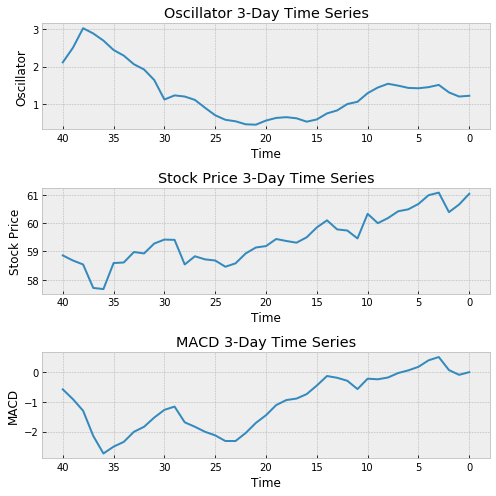

Actual Return: 0.11

Signal Index: 8113
Model Rating: Excellent


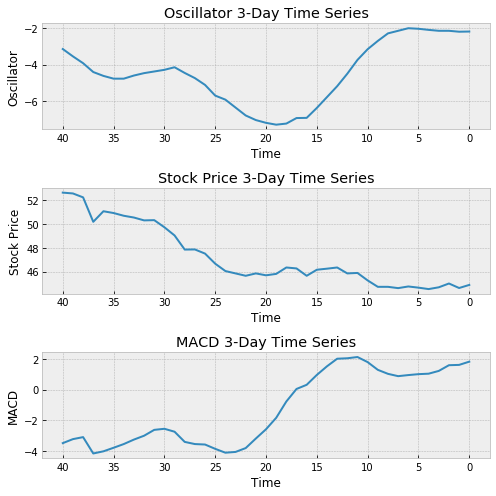

Actual Return: 1.11

Signal Index: 4453
Model Rating: Great


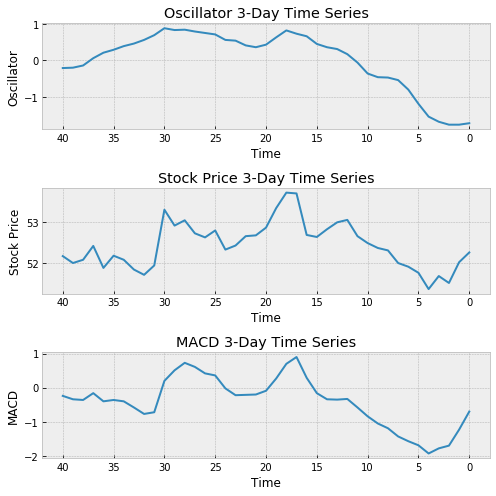

Actual Return: 0.04

Signal Index: 2680
Model Rating: Great


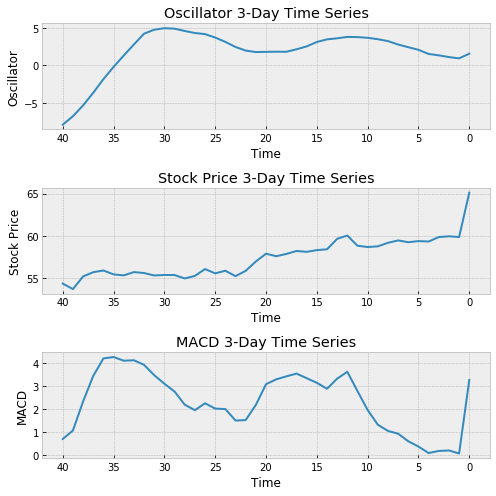

Actual Return: 0.64

Signal Index: 6852
Model Rating: Good


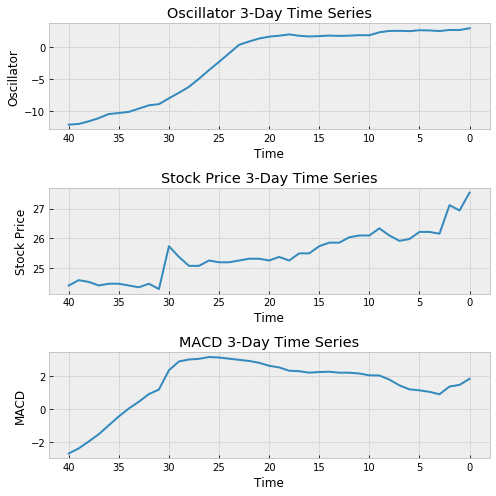

Actual Return: -1.53

Signal Index: 11819
Model Rating: Good


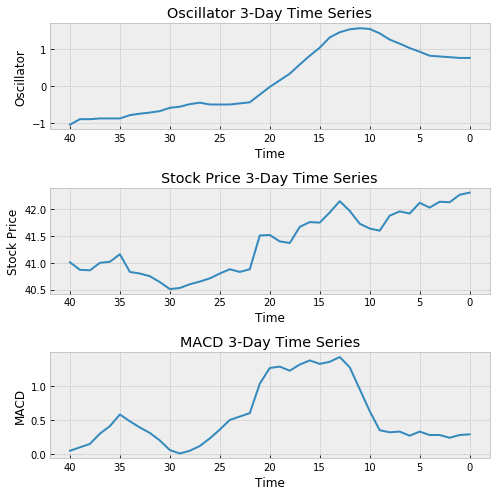

Actual Return: -0.64

Signal Index: 11241
Model Rating: Average


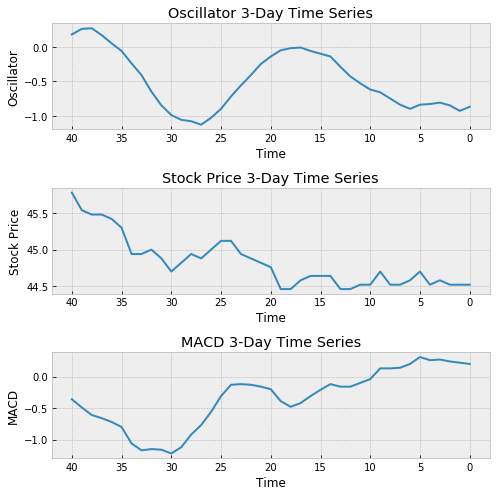

Actual Return: -0.54

Signal Index: 9078
Model Rating: Average


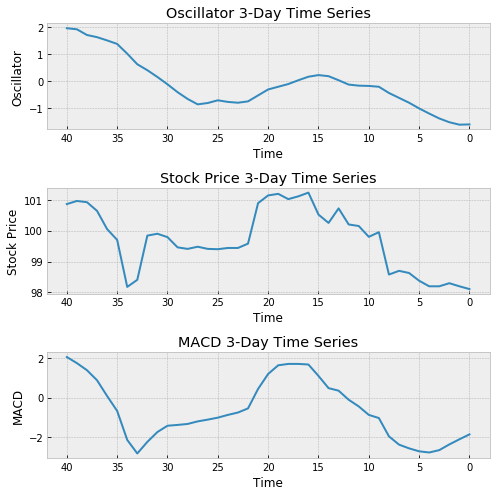

Actual Return: 0.89



In [15]:
import random

# Extracts indices of signals in each trade class
Excellent_test_set_indices = test_summary.index[test_summary['trade_class'] == 'Excellent'].tolist()
Great_test_set_indices = test_summary.index[test_summary['trade_class'] == 'Great'].tolist()
Good_test_set_indices = test_summary.index[test_summary['trade_class'] == 'Good'].tolist()
Average_test_set_indices = test_summary.index[test_summary['trade_class'] == 'Average'].tolist()

# Plot two plots for each catagories
for i in range(2):
    rand_num = random.randint(0, len(Excellent_test_set_indices))
    index = Excellent_test_set_indices[rand_num]
    EDA_Model(index, test_summary)
    
for i in range(2):
    rand_num = random.randint(0, len(Great_test_set_indices))
    index = Great_test_set_indices[rand_num]
    EDA_Model(index, test_summary)

for i in range(2):
    rand_num = random.randint(0, len(Good_test_set_indices))
    index = Good_test_set_indices[rand_num]
    EDA_Model(index, test_summary)
    
for i in range(2):
    rand_num = random.randint(0, len(Average_test_set_indices))
    index = Average_test_set_indices[rand_num]
    EDA_Model(index, test_summary)